In [1]:
import json
import pickle
from matplotlib import animation
from matplotlib import pyplot as plt
import urllib
import os
import pandas as pd
import random
import lzma
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, TextVectorization, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from math import isnan
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from collections import Counter
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# prompt: connect to google drive and load player_log.csv and text_replays.xls into dataframes

#from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Load player_log.csv
player_log_df = pd.read_csv('events.csv')

# Load text_replays.xls
text_replays_df = pd.read_excel('coded_replays.xlsx') # Replace with the actual path to your file

# Print the first few rows of each DataFrame to verify loading
print("Player Log:")
print(player_log_df.head())
print("\nText Replays:")
print(text_replays_df.head())

Player Log:
          session_id                         timestamp             event_name  \
0  23071010042645319  2023-07-10 14:08:18.198000+00:00             switch_job   
1  23071010042645319  2023-07-10 14:08:19.213000+00:00           script_fired   
2  23071010042645319  2023-07-10 14:08:19.841000+00:00  script_line_displayed   
3  23071010042645319  2023-07-10 14:08:26.529000+00:00  script_line_displayed   
4  23071010042645319  2023-07-10 14:08:27.996000+00:00  script_line_displayed   

                                          event_data   user_id  \
0  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
1  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
2  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
3  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
4  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   

                     game_state  index    job_string  task_id  session  \
0  {"job_name": "kelp-welcome"

In [4]:
# prompt: For each unique task_id in player_log_df, count the number of rows

task_counts = player_log_df.groupby('task_id').size().reset_index(name='counts')
task_counts

,task_id,counts
0,1,188
1,2,109
2,3,129
3,4,101
4,9,83
...,...,...
95,150,82
96,152,195
97,153,145
98,154,94


In [7]:
# prompt: for the player_log df, parse the json object in game_state. It contains an object called job_name. Pull the value of this object into a new column for the row.

import json

def extract_job_name(game_state_str):
  try:
    game_state = json.loads(game_state_str)
    return game_state.get('job_name', None)
  except (json.JSONDecodeError, AttributeError):
    return None

player_log_df['job_name'] = player_log_df['game_state'].apply(extract_job_name)

print(player_log_df.head())

          session_id                         timestamp             event_name  \
0  23071010042645319  2023-07-10 14:08:18.198000+00:00             switch_job   
1  23071010042645319  2023-07-10 14:08:19.213000+00:00           script_fired   
2  23071010042645319  2023-07-10 14:08:19.841000+00:00  script_line_displayed   
3  23071010042645319  2023-07-10 14:08:26.529000+00:00  script_line_displayed   
4  23071010042645319  2023-07-10 14:08:27.996000+00:00  script_line_displayed   

                                          event_data   user_id  \
0  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
1  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
2  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
3  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
4  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   

                     game_state  index    job_string  task_id  session  \
0  {"job_name": "kelp-welcome"}     45  ke

In [8]:
# prompt: for each value in the job_name column, create a new column with the value as the column name and a prefix of "job_one_shot_" For each row, put a 1 in the matching job column

# Create a list to store the new columns
new_columns = []

# Iterate through unique job names
for job_name in player_log_df['job_name'].unique():
    if job_name is not None:  # Handle potential None values
        new_column_name = f"job_one_shot_{job_name}"
        new_columns.append(new_column_name)
        player_log_df[new_column_name] = 0  # Initialize the new column with 0s


# Iterate through rows and populate the new columns
for index, row in player_log_df.iterrows():
    job_name = row['job_name']
    if job_name is not None:
        new_column_name = f"job_one_shot_{job_name}"
        if new_column_name in player_log_df.columns:
          player_log_df.loc[index, new_column_name] = 1
          #print ("index=" + str(index) + "job_name:" + job_name + "new column name: " + new_column_name)

print(player_log_df.head())

          session_id                         timestamp             event_name  \
0  23071010042645319  2023-07-10 14:08:18.198000+00:00             switch_job   
1  23071010042645319  2023-07-10 14:08:19.213000+00:00           script_fired   
2  23071010042645319  2023-07-10 14:08:19.841000+00:00  script_line_displayed   
3  23071010042645319  2023-07-10 14:08:26.529000+00:00  script_line_displayed   
4  23071010042645319  2023-07-10 14:08:27.996000+00:00  script_line_displayed   

                                          event_data   user_id  \
0  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
1  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
2  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
3  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
4  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   

                     game_state  index    job_string  task_id  session  ...  \
0  {"job_name": "kelp-welcome"}     4

In [9]:
# prompt: show the rows where job_one_shot_kelp-welcome is 1

# Filter the DataFrame to show rows where 'job_one_shot_kelp-welcome' is 1
kelp_welcome_rows = player_log_df[player_log_df['job_one_shot_kelp-welcome'] == 1]

# Print the filtered rows
kelp_welcome_rows

,session_id,timestamp,event_name,event_data,user_id,game_state,index,job_string,task_id,session,...,job_one_shot_arctic-isolated-instance,job_one_shot_kelp-start-refuge,job_one_shot_kelp-refuge-failure,job_one_shot_arctic-in-ice,job_one_shot_kelp-urchin-barren-predict,job_one_shot_bayou-shrimp-tastrophe,job_one_shot_final-final,job_one_shot_bayou-hide-n-seek,job_one_shot_bayou-reef-decision,job_one_shot_bayou-methanogen
0,23071010042645319,2023-07-10 14:08:18.198000+00:00,switch_job,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",AbleLeft,"{""job_name"": ""kelp-welcome""}",45,kelp-welcome,1,1,...,0,0,0,0,0,0,0,0,0,0
1,23071010042645319,2023-07-10 14:08:19.213000+00:00,script_fired,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",AbleLeft,"{""job_name"": ""kelp-welcome""}",46,kelp-welcome,1,1,...,0,0,0,0,0,0,0,0,0,0
2,23071010042645319,2023-07-10 14:08:19.841000+00:00,script_line_displayed,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",AbleLeft,"{""job_name"": ""kelp-welcome""}",47,kelp-welcome,1,1,...,0,0,0,0,0,0,0,0,0,0
3,23071010042645319,2023-07-10 14:08:26.529000+00:00,script_line_displayed,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",AbleLeft,"{""job_name"": ""kelp-welcome""}",48,kelp-welcome,1,1,...,0,0,0,0,0,0,0,0,0,0
4,23071010042645319,2023-07-10 14:08:27.996000+00:00,script_line_displayed,"{""http_user_agent"": ""Mozilla/5.0 (X11; CrOS x8...",AbleLeft,"{""job_name"": ""kelp-welcome""}",49,kelp-welcome,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13910,23071913052460352,2023-07-19 20:20:09.926000+00:00,fact_submitted,"{""fact_id"": ""SeaOtter.Eats.Urchin"", ""http_user...",AstuteGrass,"{""job_name"": ""kelp-welcome""}",235,kelp-welcome,152,1,...,0,0,0,0,0,0,0,0,0,0
13911,23071913052460352,2023-07-19 20:20:10.538000+00:00,complete_argument,"{""http_user_agent"": ""Mozilla/5.0 (Windows NT 1...",AstuteGrass,"{""job_name"": ""kelp-welcome""}",236,kelp-welcome,152,1,...,0,0,0,0,0,0,0,0,0,0
13912,23071913052460352,2023-07-19 20:20:10.538000+00:00,script_line_displayed,"{""http_user_agent"": ""Mozilla/5.0 (Windows NT 1...",AstuteGrass,"{""job_name"": ""kelp-welcome""}",237,kelp-welcome,152,1,...,0,0,0,0,0,0,0,0,0,0
13913,23071913052460352,2023-07-19 20:20:13.360000+00:00,script_fired,"{""http_user_agent"": ""Mozilla/5.0 (Windows NT 1...",AstuteGrass,"{""job_name"": ""kelp-welcome""}",238,kelp-welcome,152,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# prompt: for each value in the event_name column, create a new column with the value as the column name and a prefix of "event_one_shot_" For each row, put a 1 in the column for the event_name and a 0 for all other evert_ columns.

# Assuming player_log_df is already loaded as in your provided code

# Get unique event names
event_names = player_log_df['event_name'].unique()

# Create new columns for each unique event name
for event_name in event_names:
    player_log_df['event_one_shot_' + str(event_name)] = 0

# Iterate through rows and update the corresponding event columns
for index, row in player_log_df.iterrows():
    event_name = row['event_name']
    player_log_df.loc[index, 'event_one_shot_' + str(event_name)] = 1

print(player_log_df.head())

          session_id                         timestamp             event_name  \
0  23071010042645319  2023-07-10 14:08:18.198000+00:00             switch_job   
1  23071010042645319  2023-07-10 14:08:19.213000+00:00           script_fired   
2  23071010042645319  2023-07-10 14:08:19.841000+00:00  script_line_displayed   
3  23071010042645319  2023-07-10 14:08:26.529000+00:00  script_line_displayed   
4  23071010042645319  2023-07-10 14:08:27.996000+00:00  script_line_displayed   

                                          event_data   user_id  \
0  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
1  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
2  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
3  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   
4  {"http_user_agent": "Mozilla/5.0 (X11; CrOS x8...  AbleLeft   

                     game_state  index    job_string  task_id  session  ...  \
0  {"job_name": "kelp-welcome"}     4

In [11]:
# prompt: verify that each task only has one job_id

# Assuming player_log_df is already loaded as in your provided code

# Group by 'task_id' and get the unique job IDs for each task
task_job_ids = player_log_df.groupby('task_id')['job_name'].unique()

# Check if any task has more than one unique job ID
invalid_tasks = task_job_ids[task_job_ids.apply(len) > 1]

if invalid_tasks.empty:
    print("All tasks have only one job_id.")
else:
    print("Tasks with multiple job_ids:")
invalid_tasks

All tasks have only one job_id.


Series([], Name: job_name, dtype: object)

In [12]:
# prompt: create a new data frame called task_features, as a summary of player_log_df. Each row in task_features is a task_id. add the task_id column, plus columns for each of the job_one_shot_ columns. Also add columns that sum each event_one_shot_ called "event_sum_" and a column for the number of rows player_log_df for this task

# Create task_features DataFrame
task_features = pd.DataFrame()

# Add task_id column
task_features['task_id'] = player_log_df['task_id'].unique()

# Add job_one_shot columns
for col in player_log_df.columns:
    if col.startswith('job_one_shot_'):
        task_features[col] = 0

# Add event_sum columns and row count
event_columns = [col for col in player_log_df.columns if col.startswith('event_one_shot_')]
for col in event_columns:
    task_features['event_sum_' + col[len('event_one_shot_'):]] = 0
task_features['row_count'] = 0


# Aggregate data for each task_id
for task_id in task_features['task_id']:
    task_data = player_log_df[player_log_df['task_id'] == task_id]

    for col in task_features.columns:
        if col.startswith('job_one_shot_'):
            task_features.loc[task_features['task_id'] == task_id, col] = task_data[col].max()
        elif col.startswith('event_sum_'):
            event_name = col[len('event_sum_'):]
            task_features.loc[task_features['task_id'] == task_id, col] = task_data['event_one_shot_' + event_name].sum()
        elif col == 'row_count':
            task_features.loc[task_features['task_id'] == task_id, col] = len(task_data)

print(task_features.head())

   task_id  job_one_shot_kelp-welcome  job_one_shot_kelp-bull-kelp-forest  \
0        1                          1                                   0   
1        2                          0                                   1   
2        3                          0                                   0   
3        4                          0                                   0   
4        9                          0                                   0   

   job_one_shot_kelp-shop-welcome  job_one_shot_arctic-missing-whale  \
0                               0                                  0   
1                               0                                  0   
2                               1                                  0   
3                               0                                  1   
4                               0                                  0   

   job_one_shot_displaced-reef  job_one_shot_bayou-shrimp-yields  \
0                            0      

In [10]:
# prompt: for each row in task_features add the value of "response" for the matching task_id in text_replays

# Assuming task_features and text_replays_df are already loaded as in your provided code

# Add a 'response' column to task_features and initialize it with NaN
task_features['response'] = np.nan

# Iterate through rows in task_features
for index, row in task_features.iterrows():
    task_id = row['task_id']

    # Find the corresponding row in text_replays_df
    matching_row = text_replays_df[text_replays_df['task_id'] == task_id]

    # If a match is found, update the 'response' column in task_features
    if not matching_row.empty:
        task_features.loc[index, 'response'] = matching_row['response'].iloc[0]

print(task_features.head())

   task_id  job_one_shot_kelp-welcome  job_one_shot_kelp-bull-kelp-forest  \
0        1                          1                                   0   
1        2                          0                                   1   
2        3                          0                                   0   
3        4                          0                                   0   
4        9                          0                                   0   

   job_one_shot_kelp-shop-welcome  job_one_shot_arctic-missing-whale  \
0                               0                                  0   
1                               0                                  0   
2                               1                                  0   
3                               0                                  1   
4                               0                                  0   

   job_one_shot_displaced-reef  job_one_shot_bayou-shrimp-yields  \
0                            0      

In [11]:
# prompt: for each column that starts with "event_sum_", create a new column stat starts with "event_percentage_" which takes the sum and divides by the row_count

# Iterate over columns starting with "event_sum_"
for col in task_features.columns:
    if col.startswith("event_sum_"):
        # Create the new percentage column name
        new_col = col.replace("event_sum_", "event_percentage_")

        # Calculate the percentage and handle potential ZeroDivisionError
        task_features[new_col] = task_features[col] / task_features["row_count"]
        task_features[new_col] = task_features[new_col].fillna(0) # replace NaN with 0

print(task_features.head())

   task_id  job_one_shot_kelp-welcome  job_one_shot_kelp-bull-kelp-forest  \
0        1                          1                                   0   
1        2                          0                                   1   
2        3                          0                                   0   
3        4                          0                                   0   
4        9                          0                                   0   

   job_one_shot_kelp-shop-welcome  job_one_shot_arctic-missing-whale  \
0                               0                                  0   
1                               0                                  0   
2                               1                                  0   
3                               0                                  1   
4                               0                                  0   

   job_one_shot_displaced-reef  job_one_shot_bayou-shrimp-yields  \
0                            0      

<ipython-input-11-89956f1ef9a7>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_features[new_col] = task_features[col] / task_features["row_count"]
<ipython-input-11-89956f1ef9a7>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  task_features[new_col] = task_features[col] / task_features["row_count"]
<ipython-input-11-89956f1ef9a7>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

In [12]:
# prompt: view the "task_features" dataframe as google sheet

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Create a new spreadsheet
sh = gc.create('task_features')

# Open the spreadsheet and get the first sheet
worksheet = gc.open('task_features').sheet1

# Convert the DataFrame to a list of lists
rows = task_features.values.tolist()

# Insert the header row (column names)
worksheet.insert_row(task_features.columns.tolist())

# Insert the data rows
worksheet.insert_rows(rows, row=2) # Row 1 is for the header

{'spreadsheetId': '1Y9MG7x6vfR2lFhQdn7NmC-Te6igA4hisGXyIEqoDvFM',
 'updates': {'spreadsheetId': '1Y9MG7x6vfR2lFhQdn7NmC-Te6igA4hisGXyIEqoDvFM',
  'updatedRange': 'Sheet1!A2:EL101',
  'updatedRows': 100,
  'updatedColumns': 142,
  'updatedCells': 14200}}

In [13]:
# prompt: create a pandas array from the task_features dataframe which includes all the columns that start with "job_one_hot_" and all the "event_percentage_" columns
xs = []
event_cols = []


# Select columns starting with "job_one_hot_"
job_one_hot_cols = [col for col in task_features.columns if col.startswith("job_one_hot_")]

# Select columns starting with "event_percentage_"
event_cols = [col for col in task_features.columns if col.startswith("event_sum_")]

# Combine the column lists
selected_cols = ["row_count"] + job_one_hot_cols + event_cols

xs = task_features[selected_cols].values

xs

array([[188,   1,  22, ...,   0,   0,   0],
       [109,   1,  12, ...,   0,   0,   0],
       [129,   1,  29, ...,   0,   0,   0],
       ...,
       [145,   1,  16, ...,   0,   0,   0],
       [ 94,   1,  21, ...,   0,   0,   0],
       [124,   2,   8, ...,   0,   0,   0]])

In [14]:
#display the shape of xs
print("xs shape: " + str(xs.shape))

#display a sample x
xs[3]

xs shape: (100, 50)


array([101,   1,  14,  53,   1,   2,   1,   1,   0,   0,  14,   0,   2,
         1,   0,   0,   0,   0,   5,   3,   0,   0,   0,   0,   0,   0,
         0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [15]:
# prompt: create a pandas array calles "ys" for the task_features dataframe that includes the values in the "response" column

y = task_features['response'].values

#display the shape of y
print("ys shape: " + str(y.shape))

#display a sample y
y[4]

ys shape: (100,)


1.0

In [16]:
lb = LabelBinarizer()
lb.fit(y)
ys = lb.transform(y)
#ys

In [17]:
ys_flat = ys.ravel()
ys_flat

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.25)

print ("x Train Shape: " + str(x_train.shape))
print ("y Train Shape: " + str(y_train.shape))
print ("x Test Shape: " + str(x_test.shape))
print ("y Test Shape: " + str(y_test.shape))

x Train Shape: (75, 50)
y Train Shape: (75, 1)
x Test Shape: (25, 50)
y Test Shape: (25, 1)


Epoch 1/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.4742 - loss: 9.3243 - val_accuracy: 0.5500 - val_loss: 8.6140
Epoch 2/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4180 - loss: 9.0653 - val_accuracy: 0.5500 - val_loss: 8.4869
Epoch 3/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4578 - loss: 5.4109 - val_accuracy: 0.4500 - val_loss: 3.5955
Epoch 4/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5688 - loss: 3.1157 - val_accuracy: 0.5500 - val_loss: 2.8873
Epoch 5/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4320 - loss: 1.8766 - val_accuracy: 0.4000 - val_loss: 1.7176
Epoch 6/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6391 - loss: 1.1632 - val_accuracy: 0.4000 - val_loss: 1.6818
Epoch 7/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5609 - loss: 1.1024 - val_accuracy: 0.6000 - val_loss: 1.8398
Epoch 8/75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6352 - loss: 0.9185 - val_accuracy: 0.5000 - val_loss: 1.5258

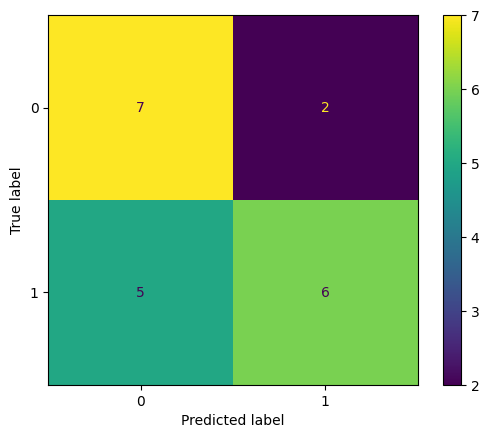

In [30]:
# prompt: build a keras sequential neural network that takes xs as an input and ys as an output

x_train_tensor = tf.convert_to_tensor(x_train)
y_train_tensor = tf.convert_to_tensor(y_train)
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)

#x_train_tensor = tf.convert_to_tensor(x_train,dtype=np.float16)
#y_train_tensor = tf.convert_to_tensor(y_train,dtype=bool)
#x_test_tensor = tf.convert_to_tensor(x_test,dtype=np.float16)
#y_test_tensor = tf.convert_to_tensor(y_test,dtype=bool)
class_weight = {0: 1.,
                1: 1.4}

model = Sequential()
model.add(Input(shape=(x_train_tensor.shape[1],)))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_test_tensor.shape[1], activation='sigmoid'))  # Output layer with softmax for multi-class, sigmoid is more a single binary
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy']) #Use use loss='categorical_crossentropy' for ?, loss="binary_crossentropy" for a single binary

model.fit(x_train_tensor, y_train_tensor, epochs=75, batch_size=32, class_weight=class_weight, validation_data=(x_test_tensor, y_test_tensor))

loss, accuracy = model.evaluate(x_test_tensor, y_test_tensor)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

#calculate the auc
from sklearn.metrics import roc_auc_score
y_pred = model.predict(x_test_tensor)
auc = roc_auc_score(y_test_tensor, y_pred)
print(f"Test AUC: {auc}")

predicted = y_pred
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()


Fold 1 Accuracy: 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Fold 1 AUC: 0.77


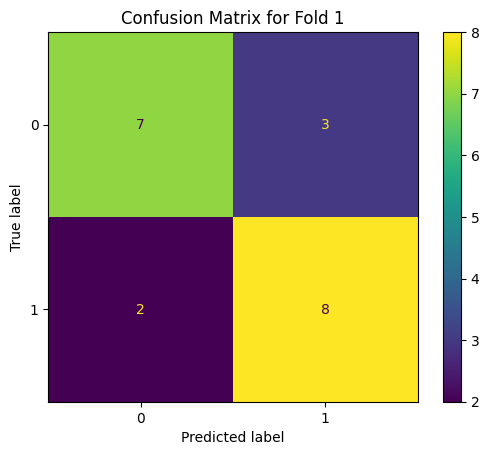

Fold 2 Accuracy: 0.6499999761581421
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Fold 2 AUC: 0.625


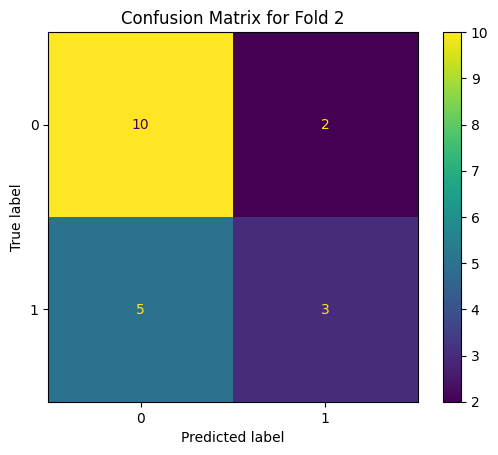

Fold 3 Accuracy: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Fold 3 AUC: 0.5757575757575757


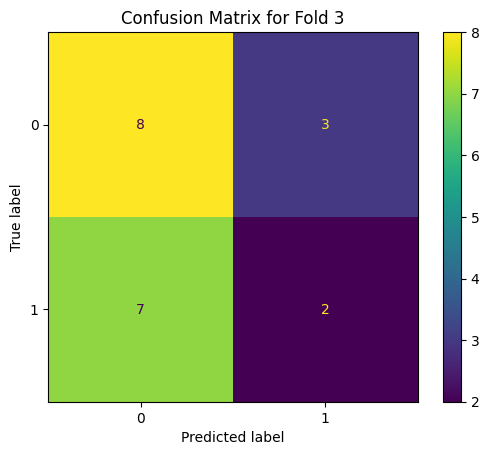

Fold 4 Accuracy: 0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Fold 4 AUC: 0.6770833333333334


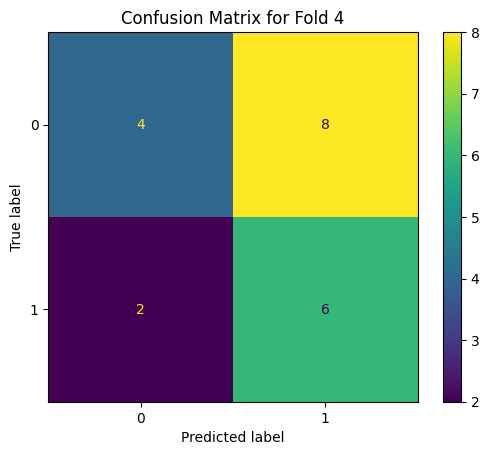

Fold 5 Accuracy: 0.6000000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Fold 5 AUC: 0.6616161616161617


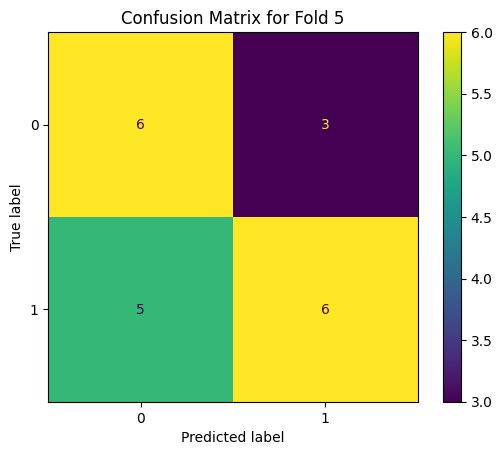

Average AUC: 0.6618914141414142
Average Accuracy: 0.6


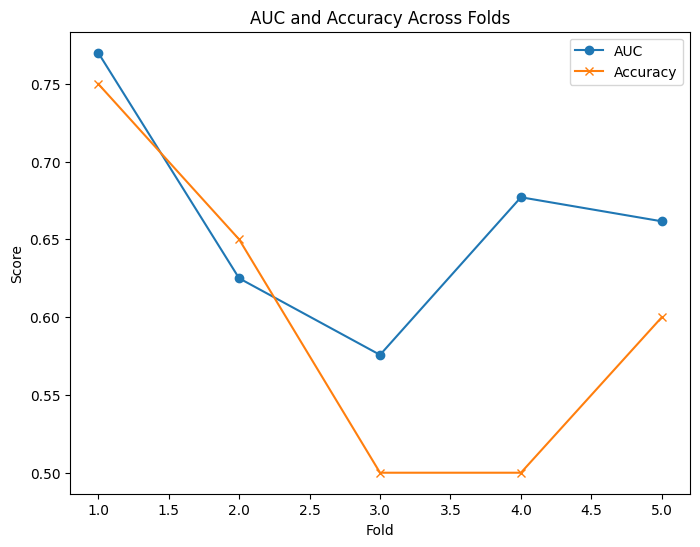

In [31]:
# prompt: run a 5-fold cross validation. Output the confusion matrix for each fold. Plot the average AUC and average accuracy.

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming xs, ys, and the model are defined as in the previous code

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
auc_scores = []
accuracy_scores = []
fold_confusion_matrices = []


for fold, (train_index, test_index) in enumerate(kf.split(xs)):
    x_train, x_test = xs[train_index], xs[test_index]
    y_train, y_test = ys[train_index], ys[test_index]

    x_train_tensor = tf.convert_to_tensor(x_train)
    y_train_tensor = tf.convert_to_tensor(y_train)
    x_test_tensor = tf.convert_to_tensor(x_test)
    y_test_tensor = tf.convert_to_tensor(y_test)

    model = Sequential()
    model.add(Input(shape=(x_train_tensor.shape[1],)))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(y_test_tensor.shape[1], activation='sigmoid'))
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

    model.fit(x_train_tensor, y_train_tensor, epochs=100, batch_size=32, verbose=0) #added verbose=0

    loss, accuracy = model.evaluate(x_test_tensor, y_test_tensor, verbose=0)
    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    accuracy_scores.append(accuracy)

    y_pred = model.predict(x_test_tensor)
    auc = roc_auc_score(y_test, y_pred)
    print(f"Fold {fold + 1} AUC: {auc}")
    auc_scores.append(auc)

    predicted = np.array([1 if x >= 0.5 else 0 for x in y_pred.ravel()])
    actual = np.array(y_test.ravel())
    conf_mat = confusion_matrix(actual, predicted)
    fold_confusion_matrices.append(conf_mat)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot()
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.show()

print(f"Average AUC: {np.mean(auc_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), auc_scores, marker='o', label='AUC')
plt.plot(range(1, 6), accuracy_scores, marker='x', label='Accuracy')

plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('AUC and Accuracy Across Folds')
plt.legend()
plt.show()

Accuracy: 0.45
Test AUC: 0.5353535353535354


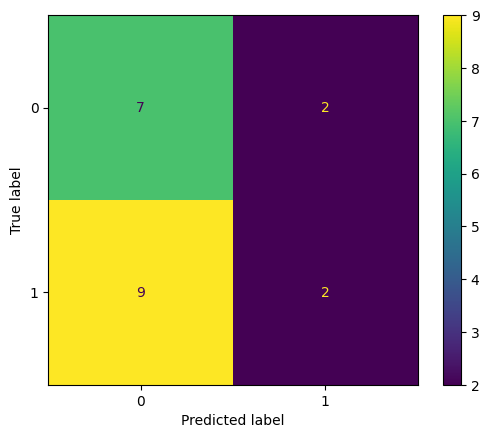

In [21]:
# prompt: create a naive bayes classifier

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier using the training data
gnb.fit(x_train, y_train.ravel())  # Use ravel to flatten the target variable

# Make predictions on the test data
y_pred = gnb.predict(x_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#calculate the AUC
from sklearn.metrics import roc_auc_score
y_pred = gnb.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc}")

predicted = y_pred
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

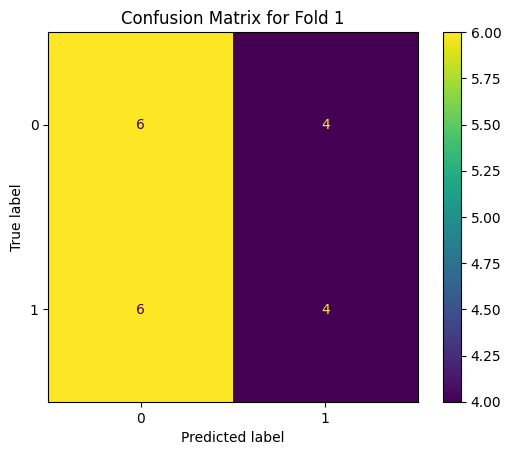

Fold 1 Accuracy: 0.5
Fold 1 AUC: 0.54


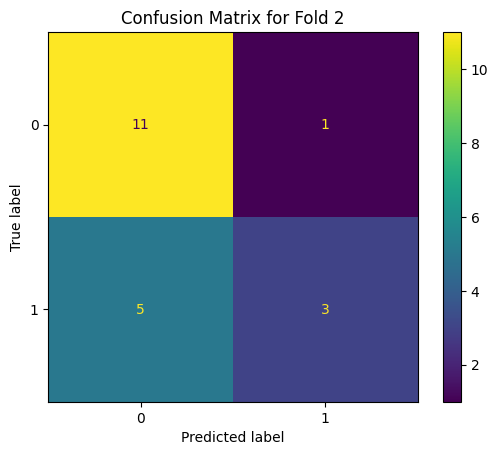

Fold 2 Accuracy: 0.7
Fold 2 AUC: 0.7135416666666667


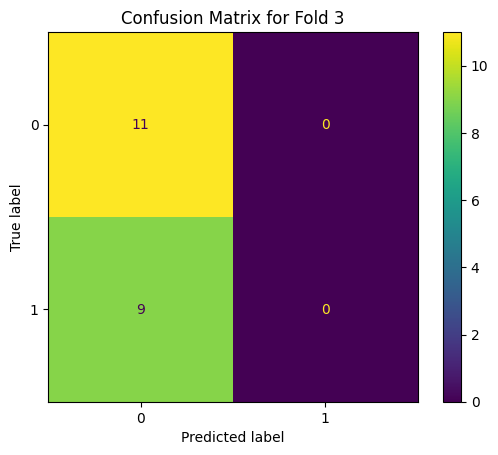

Fold 3 Accuracy: 0.55
Fold 3 AUC: 0.23232323232323235


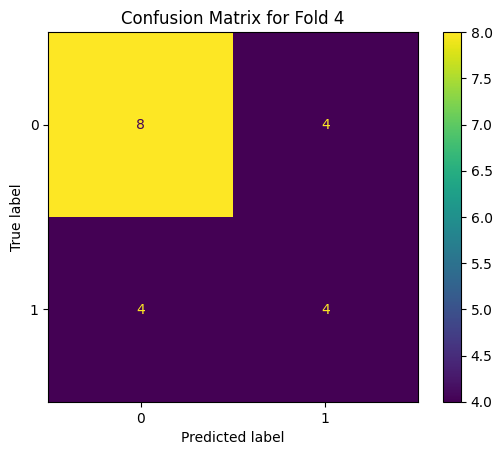

Fold 4 Accuracy: 0.6
Fold 4 AUC: 0.6770833333333333


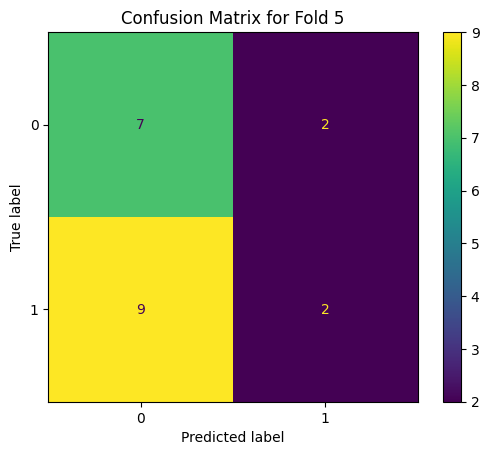

Fold 5 Accuracy: 0.45
Fold 5 AUC: 0.5353535353535354
Average AUC: 0.5396603535353536
Average Accuracy: 0.56


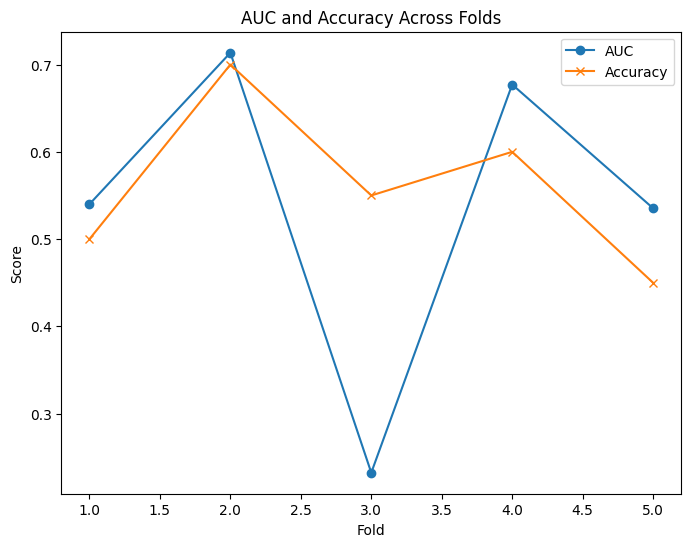

In [22]:
# prompt: run a 5-fold cross validation of the bayes model. Output the confusion matrix for each fold. Plot the average AUC and average accuracy.

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Assuming xs, ys are defined as in the previous code

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
auc_scores = []
accuracy_scores = []
fold_confusion_matrices = []

for fold, (train_index, test_index) in enumerate(kf.split(xs)):
    x_train, x_test = xs[train_index], xs[test_index]
    y_train, y_test = ys[train_index], ys[test_index]

    # Initialize and train the Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(x_train, y_train.ravel())

    # Make predictions
    y_pred = gnb.predict(x_test)
    y_pred_proba = gnb.predict_proba(x_test)[:, 1] #for AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    accuracy_scores.append(accuracy)
    auc_scores.append(auc)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    fold_confusion_matrices.append(conf_mat)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot()
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.show()

    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    print(f"Fold {fold + 1} AUC: {auc}")

print(f"Average AUC: {np.mean(auc_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), auc_scores, marker='o', label='AUC')
plt.plot(range(1, 6), accuracy_scores, marker='x', label='Accuracy')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('AUC and Accuracy Across Folds')
plt.legend()
plt.show()

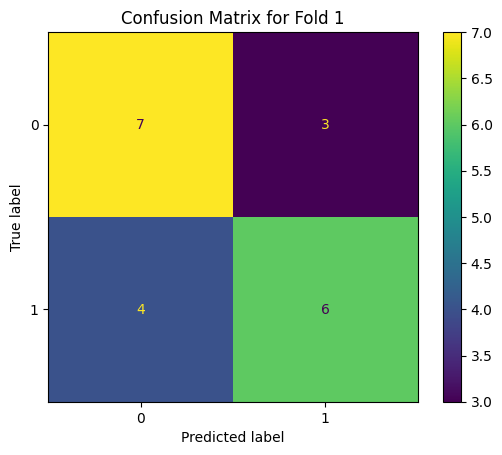

Fold 1 Accuracy: 0.65
Fold 1 AUC: 0.77


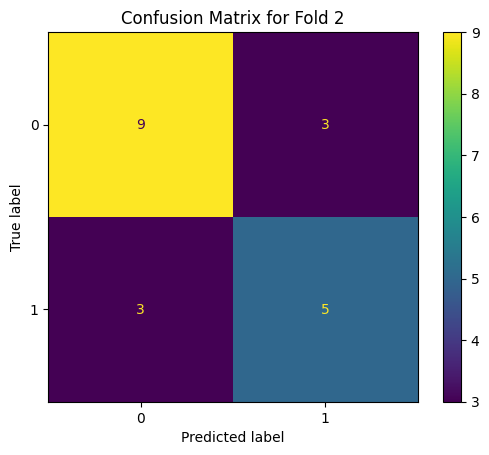

Fold 2 Accuracy: 0.7
Fold 2 AUC: 0.6875


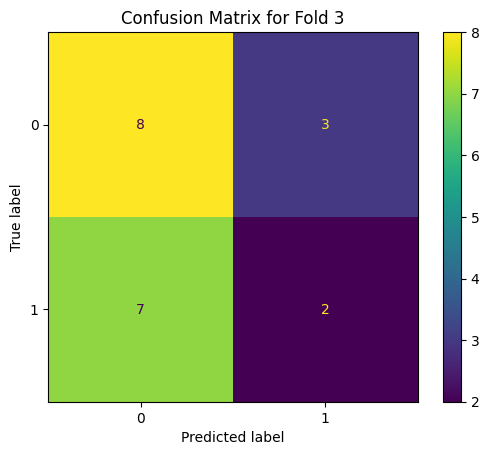

Fold 3 Accuracy: 0.5
Fold 3 AUC: 0.6060606060606061


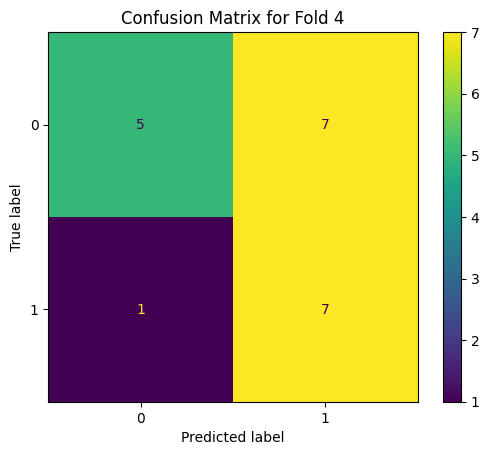

Fold 4 Accuracy: 0.6
Fold 4 AUC: 0.8541666666666667


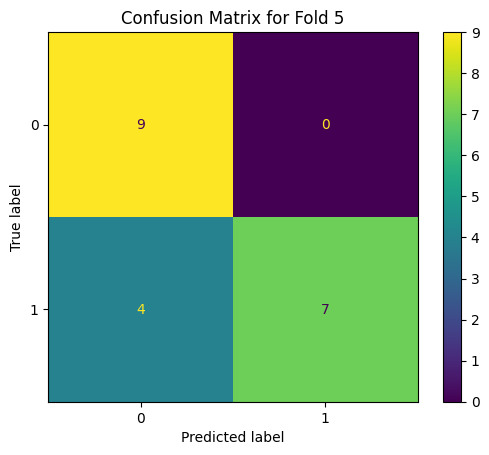

Fold 5 Accuracy: 0.8
Fold 5 AUC: 0.8787878787878787
Average AUC: 0.7593030303030304
Average Accuracy: 0.65


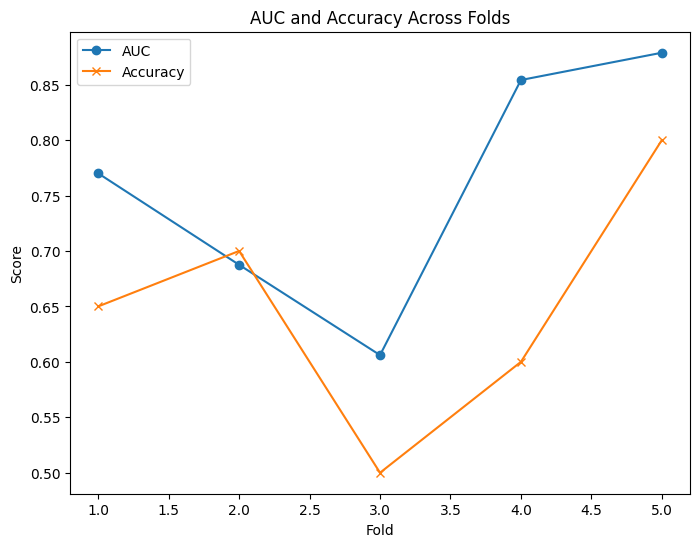

In [23]:
# prompt: run a 5-fold cross validation using a logistic regression. Output the confusion matrix for each fold. Plot the average AUC and average accuracy.

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Assuming xs and ys are defined as in your previous code

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation
auc_scores = []
accuracy_scores = []
fold_confusion_matrices = []

for fold, (train_index, test_index) in enumerate(kf.split(xs)):
    x_train, x_test = xs[train_index], xs[test_index]
    y_train, y_test = ys[train_index], ys[test_index]

    # Initialize and train the Logistic Regression model
    logreg = LogisticRegression(max_iter=1000) # Increased max_iter
    logreg.fit(x_train, y_train.ravel())

    # Make predictions
    y_pred = logreg.predict(x_test)
    y_pred_proba = logreg.predict_proba(x_test)[:, 1] #for AUC


    # Evaluate the model
    accuracy = np.mean(y_pred == y_test.ravel())
    auc = roc_auc_score(y_test, y_pred_proba)

    accuracy_scores.append(accuracy)
    auc_scores.append(auc)

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test.ravel(), y_pred)
    fold_confusion_matrices.append(conf_mat)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    disp.plot()
    plt.title(f"Confusion Matrix for Fold {fold + 1}")
    plt.show()

    print(f"Fold {fold + 1} Accuracy: {accuracy}")
    print(f"Fold {fold + 1} AUC: {auc}")

print(f"Average AUC: {np.mean(auc_scores)}")
print(f"Average Accuracy: {np.mean(accuracy_scores)}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), auc_scores, marker='o', label='AUC')
plt.plot(range(1, 6), accuracy_scores, marker='x', label='Accuracy')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('AUC and Accuracy Across Folds')
plt.legend()
plt.show()

Logistic Regression Accuracy: 0.8
Logistic Regression AUC: 0.8787878787878787


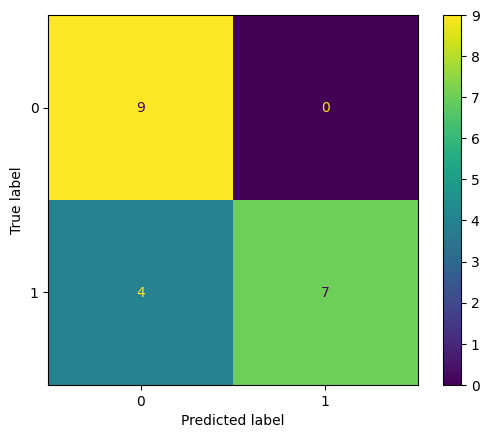

In [24]:
# prompt: create a logistic regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000) # Increase max_iter if needed

# Train the model
logreg.fit(x_train, y_train.ravel())

# Make predictions on the test set
y_pred_logreg = logreg.predict(x_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg}")

# Calculate AUC
y_pred_proba_logreg = logreg.predict_proba(x_test)[:, 1]
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)
print(f"Logistic Regression AUC: {auc_logreg}")

# Confusion Matrix
conf_mat_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=conf_mat_logreg)
disp_logreg.plot()
plt.show()